# <u><b>An Investigation Into Proportion of Urban Crimes Committed At Night</b></u>

In [1]:
# loading necessary libraries
set.seed(16)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(dplyr)
library(gridExtra)
library(broom)

options(repr.matrix.max.rows = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## <u>Introduction</u>

An understanding of both the temporal and spatial patterns of criminal activity within cities is key to developing effective prevention and intervention strategies. Previous literature has shown that occurrences of crime are determined by urban spatial configuration[1] and that crime rates are negatively correlated to ambient light level[2]. As the third largest metropolitan area in Canada, crimes in Vancouver also reflect these patterns.

In our project, we are going to use publicly available crime data from the Vancouver Police Department[3] from April 2013 to April 2023. This data contains information for the type of crime, its date and time, and location. We intend to use this data to make an inference on what proportion of crimes happen at night. We will then use this proportion and its standard deviation to hypothesize whether there is a difference in nighttime crime rate between downtown and non-downtown areas for major cities across North America.

##  <u>Tidying Up the Data</u>

We want our data be easily usable, so we will:
- remove columns we don't need
- label crimes as either occuring in downtown (Central Business District, West End, Stanley Park, or Strathcona) or elsewhere
- label crimes as either occuring at night (5pm - 6am) or day

In [2]:
# load the data from github
crimedata_AllNBHD_23_13 <- read_csv(file = "https://raw.githubusercontent.com/AllenCheng5186/STAT201-Group16-Group-Project/main/data/crimedata_AllNeighbourhoods_23_13.csv")

crimedata_AllNBHD_23_13

Rows: 428271 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2023,2,22,12,12,YUKON ST / W BROADWAY AVE,Mount Pleasant,491786,5456719
Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


_Table 1.a_: This table illustrate the overview of the raw data, including names of columns. 

In [3]:
# mutate two more colnames of region (happen in downtown or not) and whether it happened at night
crimedata_AllNBHD_23_13 <- crimedata_AllNBHD_23_13 |>
    select(!c('HUNDRED_BLOCK', 'X','Y')) |>
    mutate(YEAR = as.integer(YEAR), 
           MONTH = as.integer(MONTH), 
           DAY = as.integer(DAY),
           HOUR = as.integer(HOUR),
           MINUTE = as.integer(MINUTE)) |>
    arrange(by = desc(YEAR)) |>
    mutate(DOWNTOWN = NEIGHBOURHOOD %in% c("Central Business District", "West End", "Stanley Park", "Strathcona"),
           NIGHT = !(HOUR %in% c(6:17)))

crimedata_AllNBHD_23_13

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2023,9,14,3,32,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,1,4,7,West End,TRUE,TRUE
Break and Enter Commercial,2023,4,3,0,50,Central Business District,TRUE,TRUE
Break and Enter Commercial,2023,5,11,18,0,Central Business District,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2013,11,6,14,47,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,23,13,31,Mount Pleasant,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,Riley Park,FALSE,FALSE
Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,Riley Park,FALSE,FALSE


_Table 1.b_: Two more columns of whether the crimes (rows) happened in the duration of night (17pm to next day 6am) and in the region or downtown area (nighborhood of Central Business District, West End, Stanley Park, Strathcona) are added to the raw data table.

## <u>Preliminary Analysis</u>

### Part I: Comparing Crime Levels in Downtown to Other Parts of Vancouver

In [4]:
# summarize the count of incidents happen in two categories of region (downtown & other)
criminedata_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(downtown = sum(DOWNTOWN),
              other = sum(!DOWNTOWN)) |>
    pivot_longer(cols = downtown:other, names_to = "region", values_to = "count")

criminedata_summary

YEAR,region,count
<int>,<chr>,<int>
2013,downtown,15198
2013,other,20573
2014,downtown,16613
2014,other,22592
⋮,⋮,⋮
2022,downtown,16186
2022,other,18070
2023,downtown,14504
2023,other,14892


_Table 2.a_: This table summarizes the raw data table to calculate the number of the crimes happen in the downtown area and nondowntown area in each years from 2013 to 2023)

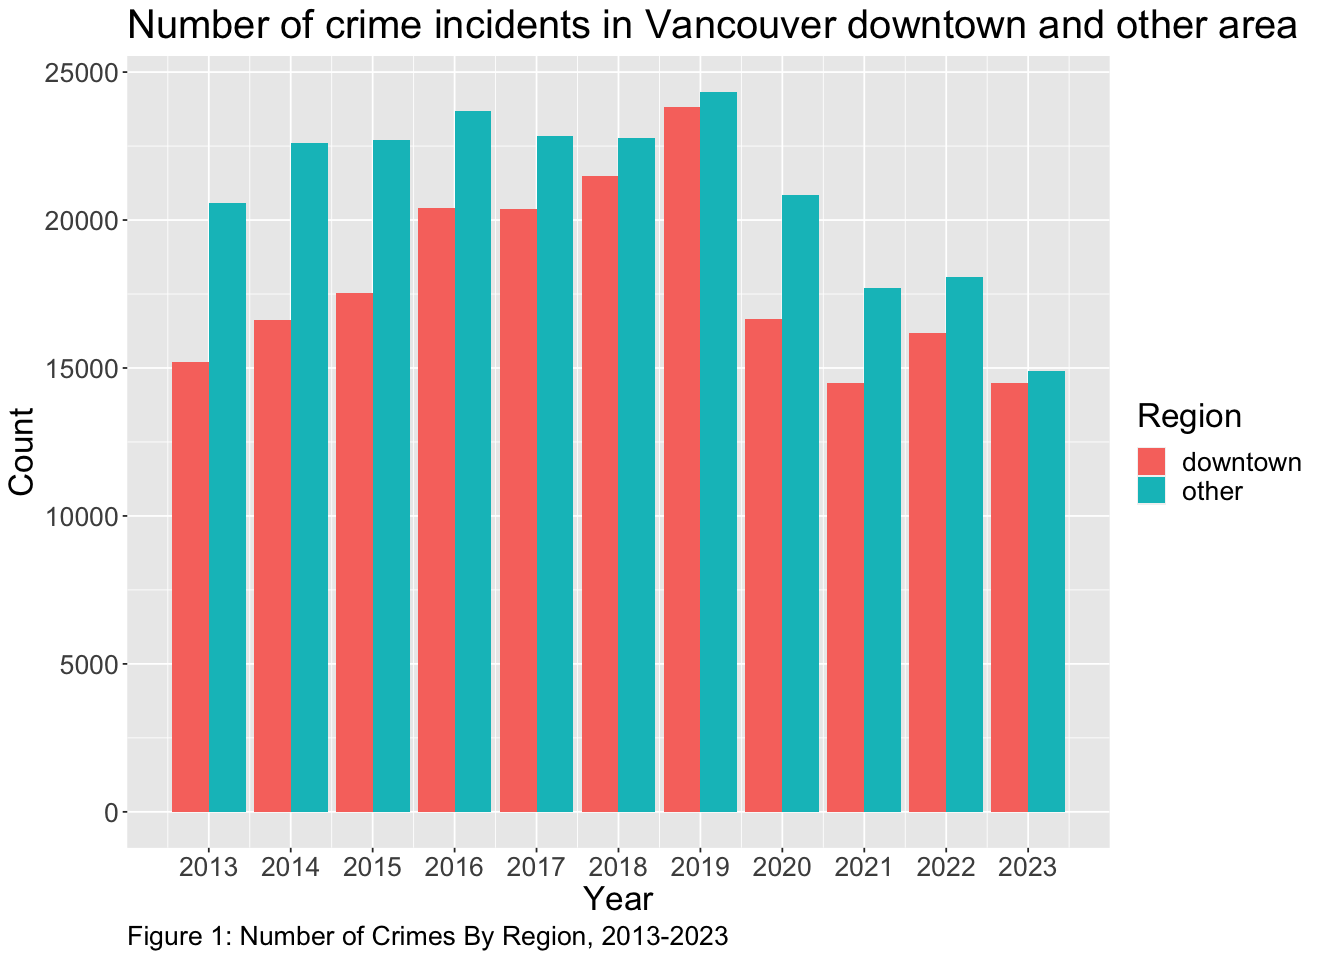

In [5]:
# visualize the count of incidents happen in two categories of area along time change
options(repr.plot.width = 11, repr.plot.height = 8)

crimedata_AllNBHD_23_13_barplot <-  criminedata_summary |>
    ggplot(aes(x = YEAR, y = count, fill = region)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Region") +
    ggtitle("Number of crime incidents in Vancouver downtown and other area") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 1: Number of Crimes By Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crimedata_AllNBHD_23_13_barplot

We see in Figure 1, more crime occurs in other parts of the city compared to downtown. There appears to be a steady growth in crime from 2013 - 2019, then a decline in crime till the present. The amount of crime in downtown varies from approximately 15000 - 23000, while the amount of crime in other parts of the city range from approximately 15000 - 24000.

### Part II: Comparing Daytime/Nighttime Crime Levels in Downtown to Other Parts of Vancouver

In [6]:
# summarize the count of the incidents happen in night or day (time) and downtown or non downtown (region)
criminedata_downtown_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "downtown",
              aggregate = sum(DOWNTOWN),
              Night = sum(DOWNTOWN & NIGHT),
              Day = sum(DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")
criminedata_other_summary <- crimedata_AllNBHD_23_13 |>
    group_by(YEAR) |>
    summarize(region = "other",
              aggregate = sum(!DOWNTOWN),
              Night = sum(!DOWNTOWN & NIGHT),
              Day = sum(!DOWNTOWN & !NIGHT)) |>
    pivot_longer(cols = Night:Day, names_to = "time", values_to = "count")

crime_AllNBHD_AllTime_summary <- bind_rows(criminedata_downtown_summary, criminedata_other_summary) |>
    arrange(YEAR)

crime_AllNBHD_AllTime_summary

YEAR,region,aggregate,time,count
<int>,<chr>,<int>,<chr>,<int>
2013,downtown,15198,Night,8392
2013,downtown,15198,Day,6806
2013,other,20573,Night,10804
2013,other,20573,Day,9769
⋮,⋮,⋮,⋮,⋮
2023,downtown,14504,Night,7893
2023,downtown,14504,Day,6611
2023,other,14892,Night,8086
2023,other,14892,Day,6806


_Table 3.a_ : This table shows the total number of and count of crimes for time (night) in each year. 

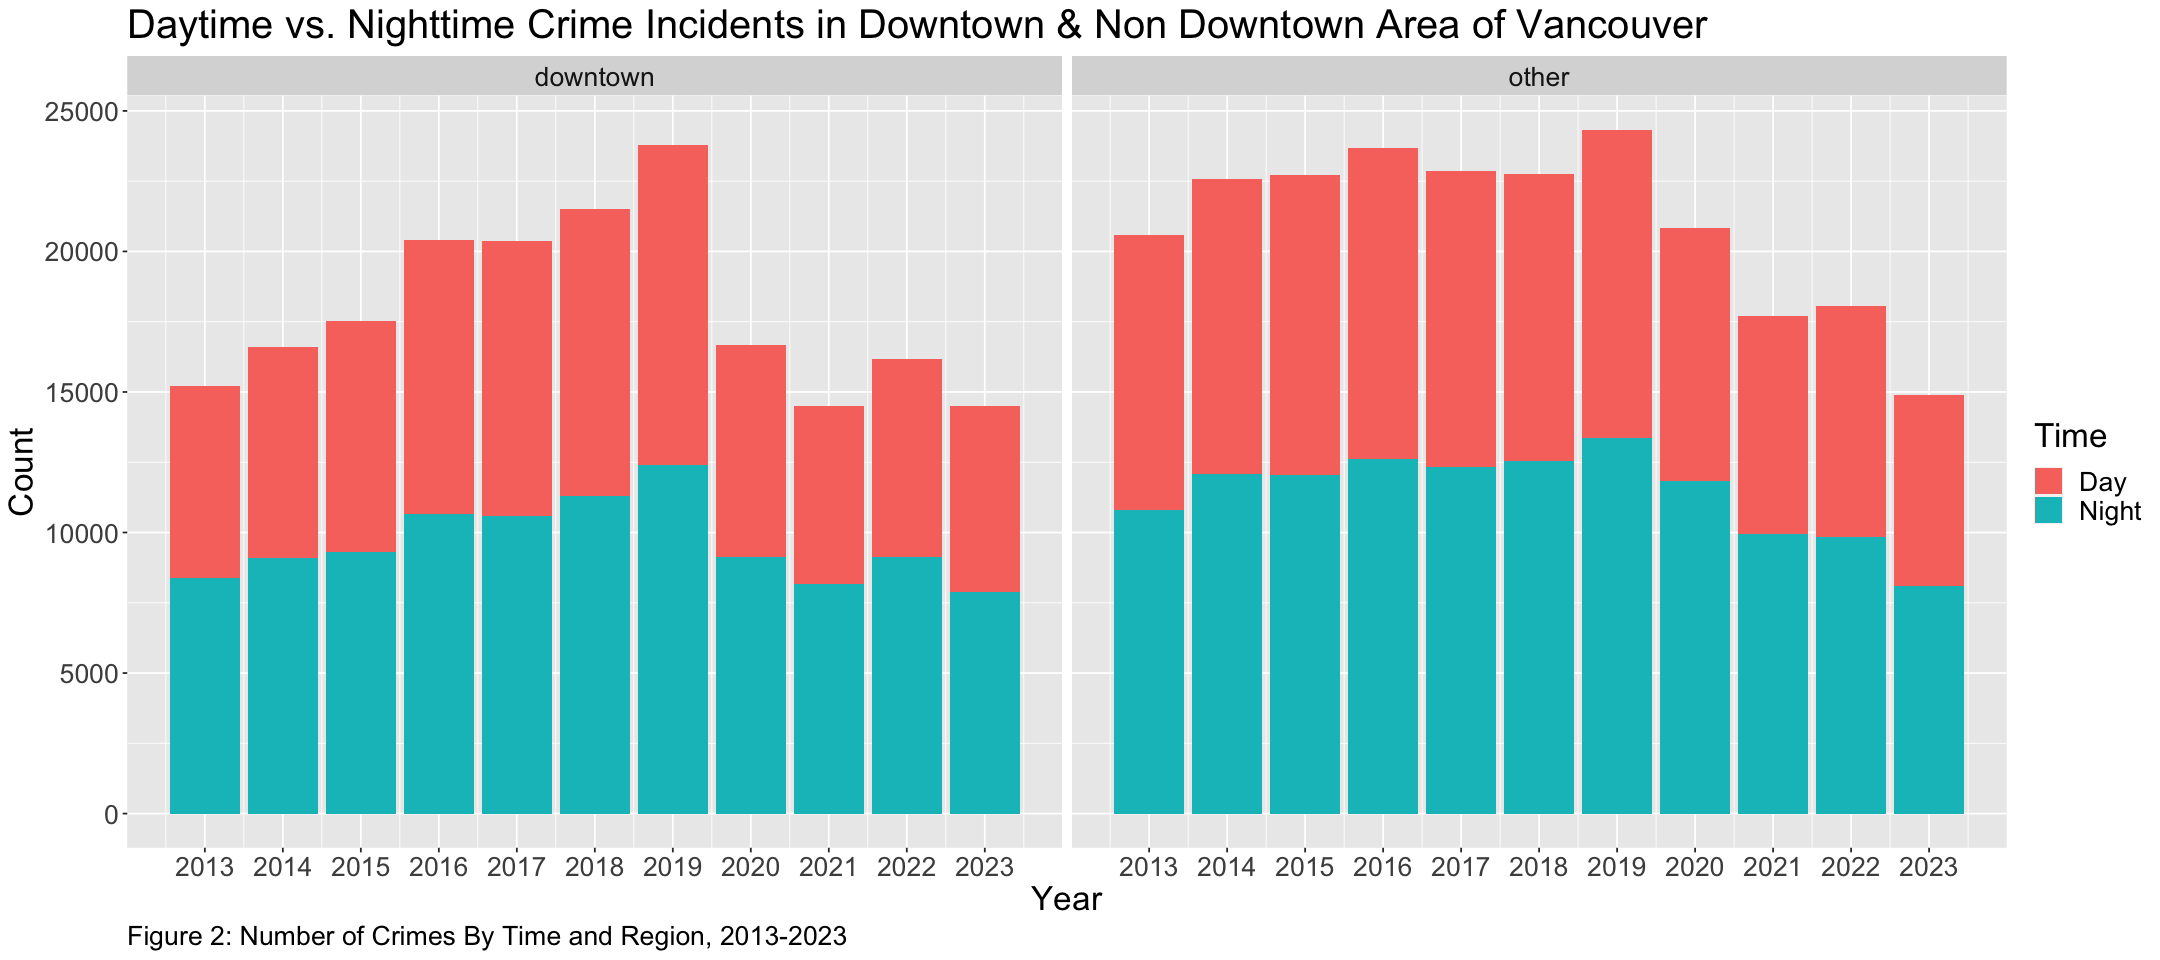

In [7]:
# visualize the count of crimes happened in the two time periods and regions along the years
options(repr.plot.width = 18, repr.plot.height = 8)

crime_AllNBHD_AllTime_summary_bar <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Count", fill = "Time") +
    ggtitle("Daytime vs. Nighttime Crime Incidents in Downtown & Non Downtown Area of Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region)) + 
    labs(caption = "Figure 2: Number of Crimes By Time and Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crime_AllNBHD_AllTime_summary_bar

In Figure 2, we see that downtown had the most crime in 2019 and 2021/2023 had the least crime. For non-downtown areas, the most crime also happened 2019 and the least crime happened in 2021/2023.

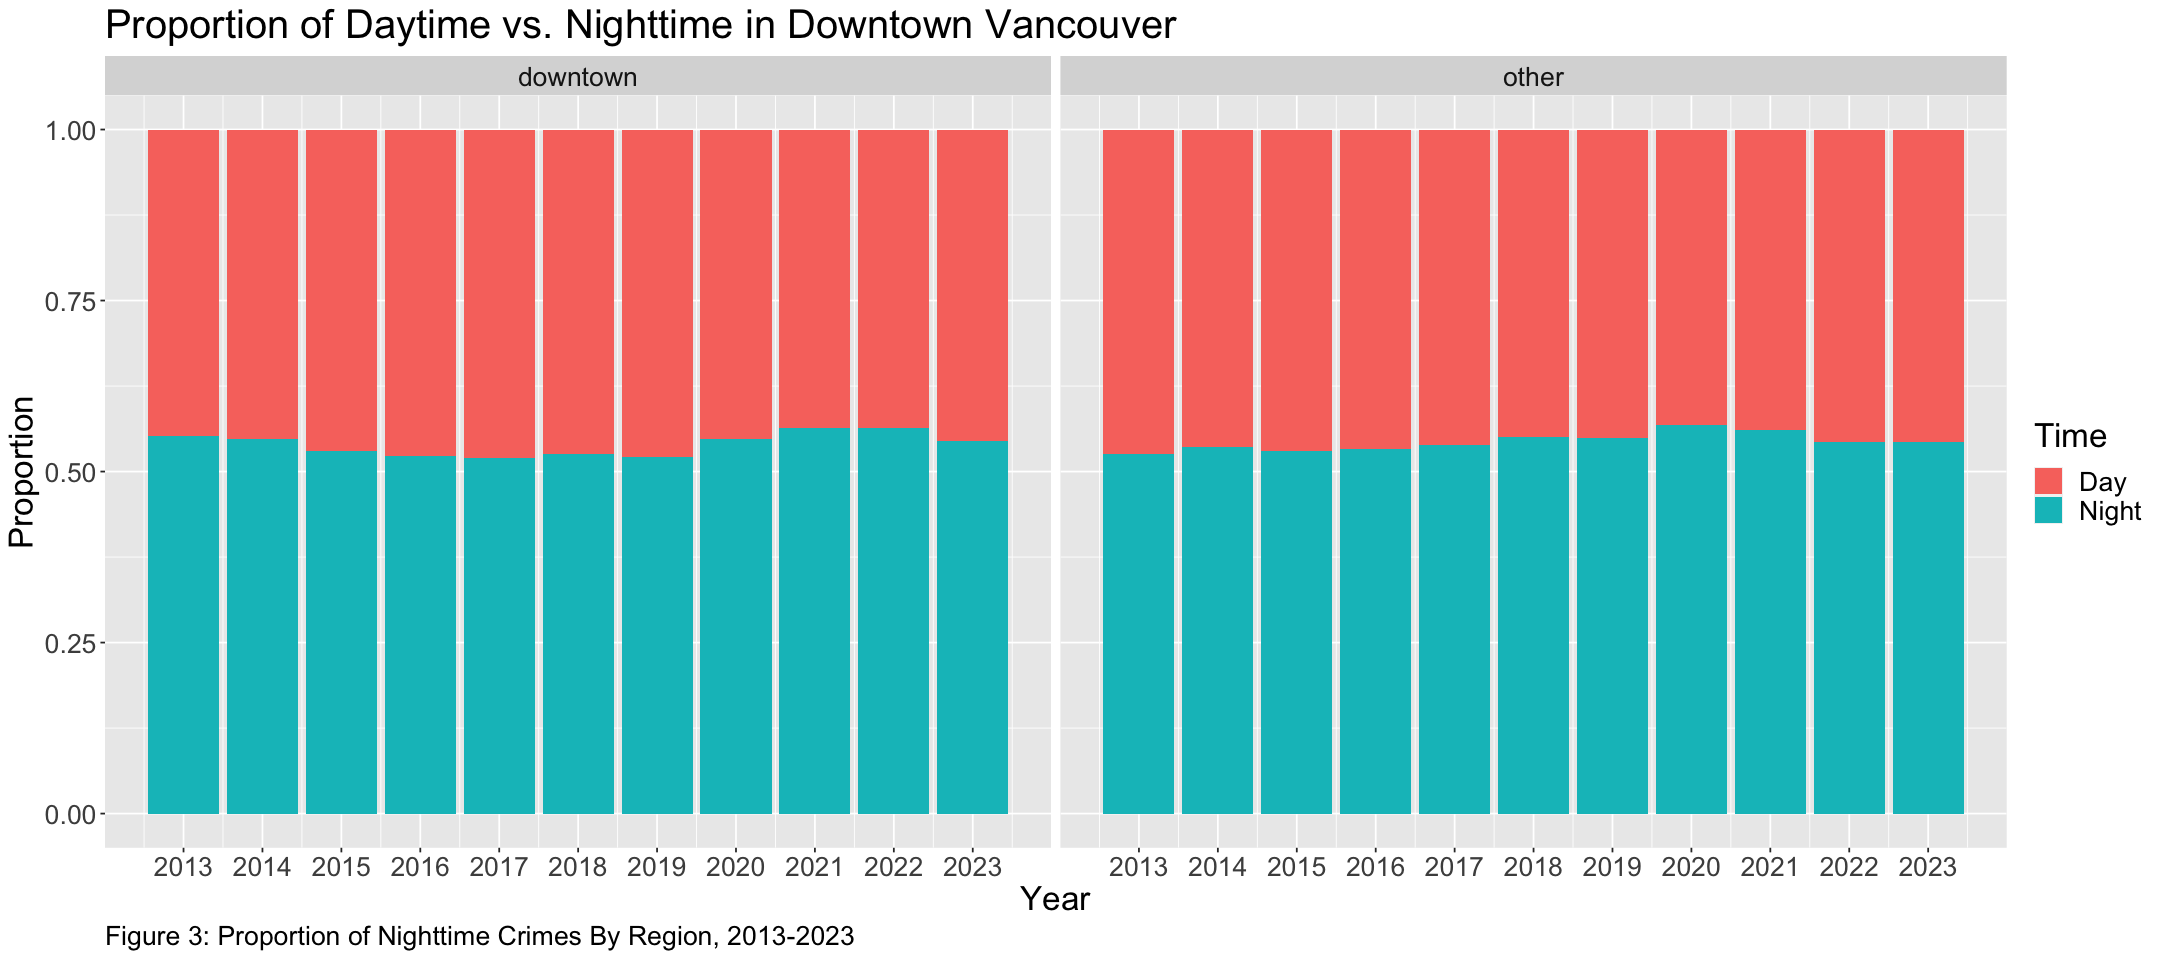

In [8]:
# visualize the proportion of the crimes happened at night or day in two regions
options(repr.plot.width = 18, repr.plot.height = 8)
crime_AllNBHD_AllTime_summary_prop <- crime_AllNBHD_AllTime_summary |>
    ggplot(aes(x = YEAR, y = count, fill = time)) +
    geom_bar(stat = "identity",position = "fill") +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    labs(x = "Year", y = "Proportion", fill = "Time") +
    ggtitle("Proportion of Daytime vs. Nighttime in Downtown Vancouver") +
    theme(text = element_text(size = 20)) +
    facet_grid(cols = vars(region)) + 
    labs(caption = "Figure 3: Proportion of Nighttime Crimes By Region, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

crime_AllNBHD_AllTime_summary_prop

In Figure 3, for both downtown and non-downtown areas, the proportion of crimes that occur at night is a little above 50%. This value seems to fluctuate a little bit every year but seems constant.

In [9]:
# calculate the sample statistics of average count and overall proportion for past 10 years average
crime_average <- crime_AllNBHD_AllTime_summary |>
    group_by(region, time) |>
    summarize(average = round(mean(count))) |>
    ungroup() |>
    mutate(prop = average/sum(average))

crime_average

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


region,time,average,prop
<chr>,<chr>,<dbl>,<dbl>
downtown,Day,8293,0.2130015
downtown,Night,9640,0.2475985
other,Day,9594,0.2464170
other,Night,11407,0.2929830


_Table 3.b_ : This table shows the average count and overall proportion for entire past 10 years data. 

## <u>Taking a Sample</u>

We have access to the entire population because this crime data is publicly available and regularly updated. However, as we've seen above, there don't appear to be a significant difference in the ratio of crimes committed in downtown/non-downtown over the last 10 years. Additionally, the proportion of crime committed at night in both downtown/non-downtown is mostly consistent every year. For these reasons, we will use all the crime data for 2022 (because it's the most recent completed year) as our sample. Below is a brief analysis about the sample:

In [10]:
# since the 2023 data is not completed, we will focus on 2022 data and use as our sample
crime_sample <- crimedata_AllNBHD_23_13 |>
    filter(YEAR == 2022)

crime_sample

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,NEIGHBOURHOOD,DOWNTOWN,NIGHT
<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
Break and Enter Commercial,2022,1,5,7,34,West End,TRUE,FALSE
Break and Enter Commercial,2022,1,3,16,19,West End,TRUE,FALSE
Break and Enter Commercial,2022,6,17,5,16,West End,TRUE,TRUE
Break and Enter Commercial,2022,3,15,5,14,West End,TRUE,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Vehicle Collision or Pedestrian Struck (with Injury),2022,4,16,19,37,Renfrew-Collingwood,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,9,9,18,46,Hastings-Sunrise,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,8,31,20,1,Arbutus Ridge,FALSE,TRUE
Vehicle Collision or Pedestrian Struck (with Injury),2022,10,12,8,27,Mount Pleasant,FALSE,FALSE


_Table 4.a_ : The table shows overview the sample of 2022 drawed from the raw data.

In [11]:
# overview of sample (2022) statistics 
crime_sample_summary <- crime_sample |>
    group_by(DOWNTOWN) |>
    summarize(aggregate = n(),
              night = sum(NIGHT),
              day = sum(!NIGHT)) |>
    pivot_longer(cols = night:day, names_to = "time", values_to = "count")

crime_sample_summary

DOWNTOWN,aggregate,time,count
<lgl>,<int>,<chr>,<int>
FALSE,18070,night,9828
FALSE,18070,day,8242
TRUE,16186,night,9118
TRUE,16186,day,7068


_Table 4.b_ : This tables shows the statistics of the total number of crimes happen in the downtown and nondowntown areas  associated with the count of crimes in two time durations.

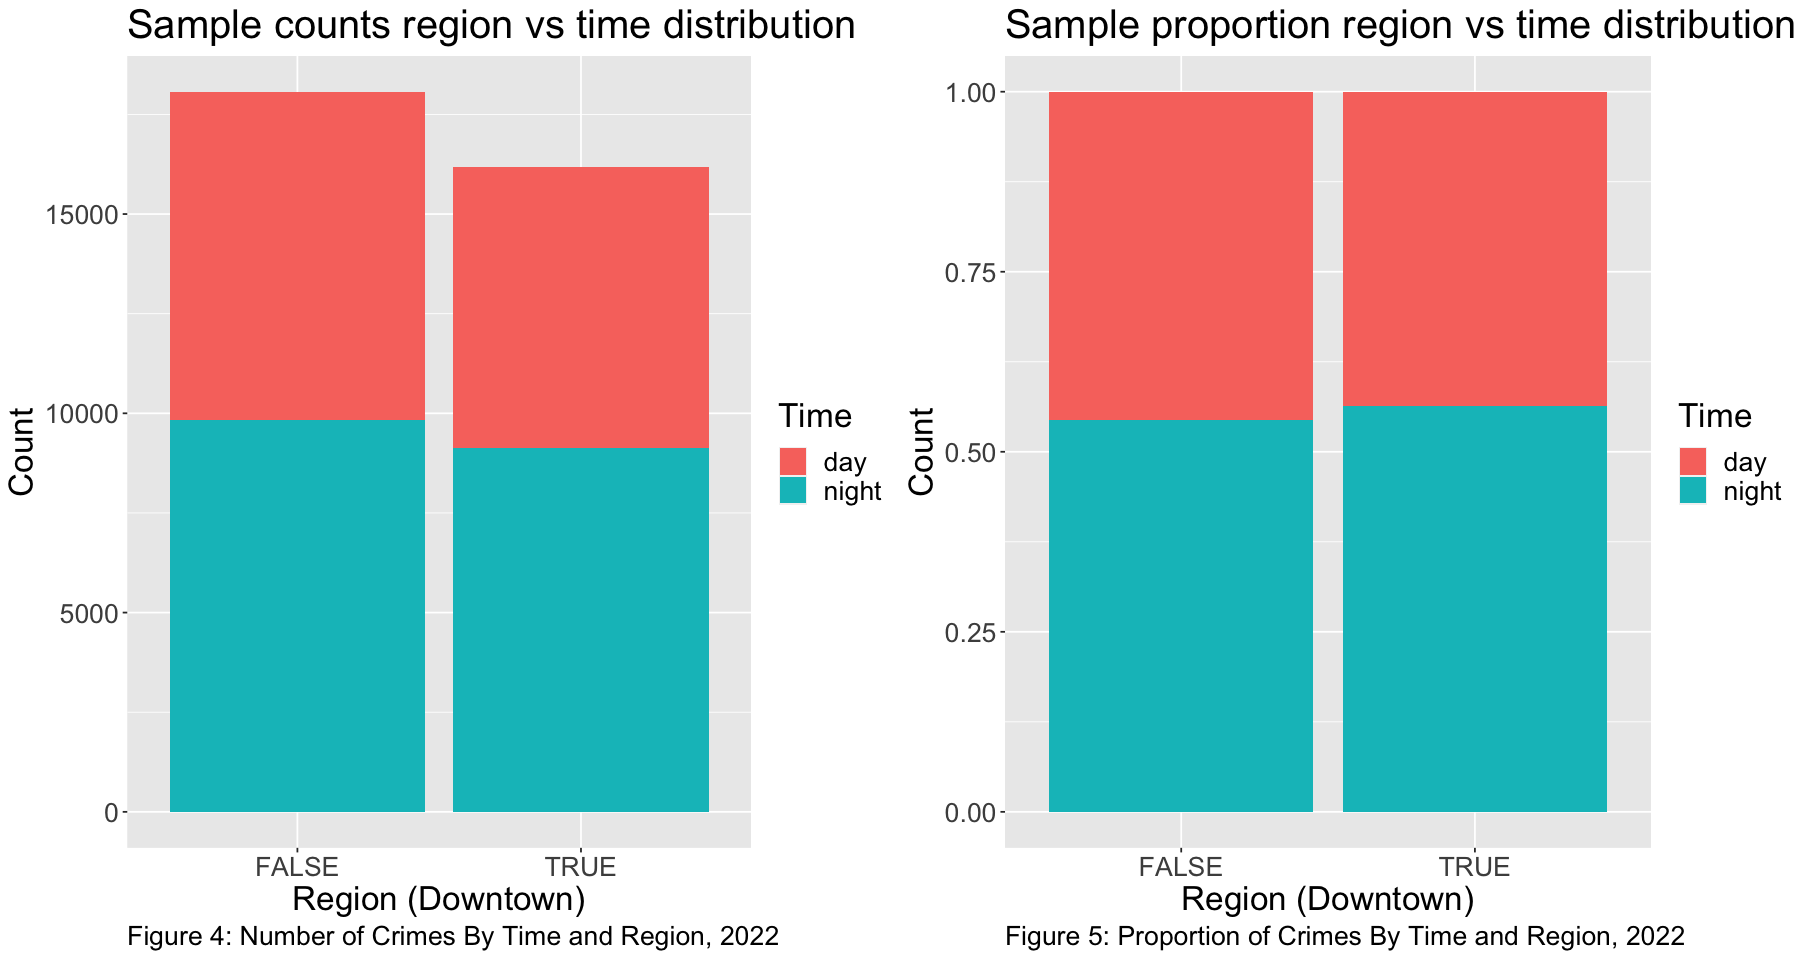

In [12]:
# visualize sample statistics distribution 

crime_sample_summary_count_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample counts region vs time distribution") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 4: Number of Crimes By Time and Region, 2022") +
    theme(plot.caption = element_text(hjust = 0))
crime_sample_summary_prop_dist <- crime_sample_summary |>
    ggplot(aes(x = DOWNTOWN, y = count, fill = time)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Region (Downtown)", y = "Count", fill = "Time") +
    ggtitle("Sample proportion region vs time distribution") +
    theme(text = element_text(size = 20)) + 
    labs(caption = "Figure 5: Proportion of Crimes By Time and Region, 2022") +
    theme(plot.caption = element_text(hjust = 0))

options(repr.plot.width = 15, repr.plot.height = 8)
plot_grid(crime_sample_summary_count_dist,
          crime_sample_summary_prop_dist,
          ncol = 2)

In Figure 4, we see that more crime occurs in non-downtown areas for both daytime and nighttime. In Figure 5, we see that downtown has a slightly more crime that occurs during the night, but we are unsure whether there is a significant difference.

## <u>Hypothesis Testing On 2022 Data</u>

### Part I: Using R's Prop.Test

Below are the summary statistics for nighttime crime in downtown and non-downtown areas. We are trying to find out whether there is a significant difference between these two values, so we will use R's built-in prop.test function to do the statistical test for us. Since we want to know if these values are equal, this is a two sided test. We will also obtain a 90% confidence interval for the difference between nighttime crime in downtown and non-downtown areas. There is only 1 test, so we will not use a continuity correction. Here is our null and alternative hypothesis:

$$H_0: P_{downtown-night-crime} = P_{non-downtown-night-crime}$$
$$H_a: P_{downtown-night-crime} \neq P_{non-downtown-night-crime}$$

In [13]:
# getting number of nighttimes and total crimes per area
crime_sample_summary <- crime_sample_summary |>
    group_by(DOWNTOWN) |>
    mutate(prop = count /sum(count)) |>
    filter(time == 'night')

crime_sample_summary

DOWNTOWN,aggregate,time,count,prop
<lgl>,<int>,<chr>,<int>,<dbl>
FALSE,18070,night,9828,0.5438849
TRUE,16186,night,9118,0.5633263


_Table 5.a_ : This tables shows the statistics of the total number of crimes happen in the downtown and nondowntown areas associated with the count of crimes in two time durations and proportion $\frac{\text{count}}{\text{aggregate}}$.

In [14]:
# two-tailed test on two proportions 
results <- tidy(
    prop.test(x = c(9118, 9828), 
              n = c(16186, 18070), 
              alternative = "two.sided", 
              conf.level = 0.9, 
              correct = F)
)
results

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.5633263,0.5438849,13.05565,0.0003023712,1,0.01059491,0.02828797,2-sample test for equality of proportions without continuity correction,two.sided


_Table 5.b_ : This table shows the result of the proportional hypothesis test. The `p-value` is the probability of observing a differences in the proportion of crimes happened in the night in two different areas (downtown and nondowntown) at least as different as hypothesis of two proportions are same. The value of it, $0.0003$ shows that the null hypothesis is rear. It suggests a 90% confidence interval to have a sense of truely difference is mostly positive, which means the proportion for nondowntown area is greater than downtown area.

In [15]:
# obtaining the p-value from the statistical test
p_value <- results |>
    select(p.value) |>
    pull()
p_value

[1] 0.0003023712

In [29]:
# obtaining the confidence interval for difference in proportions (downtown - non-downtown)
conf_interval <- tibble(
    lower_ci = results$conf.low,
    upper_ci = results$conf.high,
    width = upper_ci - lower_ci
)
conf_interval

lower_ci,upper_ci,width
<dbl>,<dbl>,<dbl>
0.01059491,0.02828797,0.01769306


_Table 5.c_: The table shows the upper bound, lower bound and the width (upper - lower) for 90% confidence interval using the hypothesis approach.

For the 2022 sample, we have obtained a p-value of 0.0003 and the confidence interval for difference in proportions between downtown and non-downtown areas is (0.0106, 0.0283).

### Part II: Using A Bootstrapping Approach

Another way we could conduct a confidence interval is to use bootstrapping. We will create 100 bootstrap samples using the 2022 data (with a seed of 16, set in the first cell). We will then use the bootstrap samples to calculate the difference in proportions between downtown and non-downtown for each sample, which will then be used to create the bootstrap.

In [28]:
# taking the bootstrap samples
set.seed(16)

boostrap_sample <- crime_sample |>
    rep_sample_n(size = nrow(crime_sample), replace = TRUE, reps = 100) |>
    group_by(replicate) |>
    mutate(DOWNTOWN = NEIGHBOURHOOD %in% c("Central Business District", "West End", "Stanley Park", "Strathcona"),
           NIGHT = !(HOUR %in% c(6:17))) |>
    summarize(downtown_night_count = sum(DOWNTOWN == TRUE & NIGHT == TRUE),
              downtown_aggregate = sum(DOWNTOWN == TRUE),
              other_night_count = sum(DOWNTOWN != TRUE & NIGHT == TRUE),
              other_aggregate = sum(DOWNTOWN != TRUE)) |>
    group_by(replicate) |>
    summarize(prop_downtown = downtown_night_count / downtown_aggregate,
              prop_other = other_night_count / other_aggregate,
              diff = prop_downtown - prop_other) |>
    pull(diff)

# obtaining the confidence interval for difference in proportions
conf_interval_bs <- tibble(lower_ci = quantile(x = boostrap_sample, probs = 0.05),
                           upper_ci = quantile(x = boostrap_sample, probs = 0.95), 
                           width = upper_ci - lower_ci) 

conf_interval_bs

lower_ci,upper_ci,width
<dbl>,<dbl>,<dbl>
0.01014692,0.02698974,0.01684282


_Table 5.d_: The table shows the upper bound, lower bound and the width (upper - lower) for 90% confidence interval using the boostrap approach.

Using this bootstrapping approach, our confidence interval is (0.0105, 0.0280). This is very similar to the confidence interval we obtained using prop.test, but it is very slighly smaller. We think that both confidence intervals are good estimates because the first approach used the theory based confidence interval appraoch and our sample size is large enough that by the central limit theorem (CLT) we can rely on the result and the second bootstrapping approach took samples from our sample of the population data with replacement. In this case, since our population parameter is something that the CLT applies to, it makes sense to use the theory based approach since its much more computationally expensive to use a bootstrapping appraoch.

## <u>Conducting Hypothesis Tests On 2013-2023 Data</u>

### Part I: Hypothesis Testing by Year

In addition to the hypothesis test above for 2022, we have also conducted hypothesis tests for each year in our data. We are still trying to determine whether the true proportion of nighttime crime differs between downtown and non-downtown areas. We will construct 10 confidence intervals and find 10 p-values (one for each year). We will then use an $\alpha = 0.05$ to determine whether we will reject the null hypothesis.

In [18]:
options(repr.matrix.max.rows = 11)

alpha <- 0.05

# conducting the same statistical test for each year in our data
prop_test_13_23 <- crime_AllNBHD_AllTime_summary |>
    filter(time == "Night") |>
    pivot_wider(names_from = region, values_from = c(aggregate, count)) |>
    select(YEAR, time, aggregate_downtown, count_downtown, aggregate_other, count_other) |>
    rowwise() |>
    group_by(YEAR) |>
    summarize(prop_test = list(tidy(prop.test(x = c(count_downtown, count_other), 
                                      n = c(aggregate_downtown, aggregate_other), 
                                      alternative = "two.sided", 
                                      conf.level = 0.9, 
                                      correct = F)))) |>
    pull(prop_test) |>
    bind_rows() |>
    mutate(year = seq(2013, 2023)) |>
    select(year, estimate1:conf.high, alternative) |>
    mutate(reject = p.value < alpha)

prop_test_13_23

year,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,alternative,reject
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
2013,0.5521779,0.5251543,25.67065468,4.049381e-07,1,0.018259207,0.035787972,two.sided,TRUE
2014,0.5482454,0.5352780,6.48220898,1.089595e-02,1,0.004593289,0.021341462,two.sided,TRUE
2015,0.5307113,0.5300855,0.01554749,9.007693e-01,1,-0.007629577,0.008881204,two.sided,FALSE
2016,0.5221841,0.5335389,5.67226058,1.723523e-02,1,-0.019197013,-0.003512528,two.sided,TRUE
2017,0.5198409,0.5393268,16.41193505,5.096333e-05,1,-0.027397179,-0.011574713,two.sided,TRUE
2018,0.5249477,0.5512409,30.76270946,2.915878e-08,1,-0.034089009,-0.018497498,two.sided,TRUE
2019,0.5215930,0.5484242,34.82527835,3.606602e-09,1,-0.034307404,-0.019354997,two.sided,TRUE
2020,0.5472932,0.5683726,16.69242192,4.395623e-05,1,-0.029568559,-0.012590124,two.sided,TRUE
2021,0.5630565,0.5610637,0.12855697,7.199329e-01,1,-0.007148719,0.011134294,two.sided,FALSE


_Table 6.a_ : This table shows the results of the proportional hypothesis tests in every years for past decade. Only three of results suggest to do not reject the null hypothesis that the proportions for two areas are same. 

After running the hypothesis test for proportions for each year, we have obtained a p-values ranging from $3.6\times10^{-9}$ to $0.90$. Using these p-values, we have rejected 8/11 null hypotheses. We will then use the test statistics and the confidence intervals for difference in proportions to create the figure below.

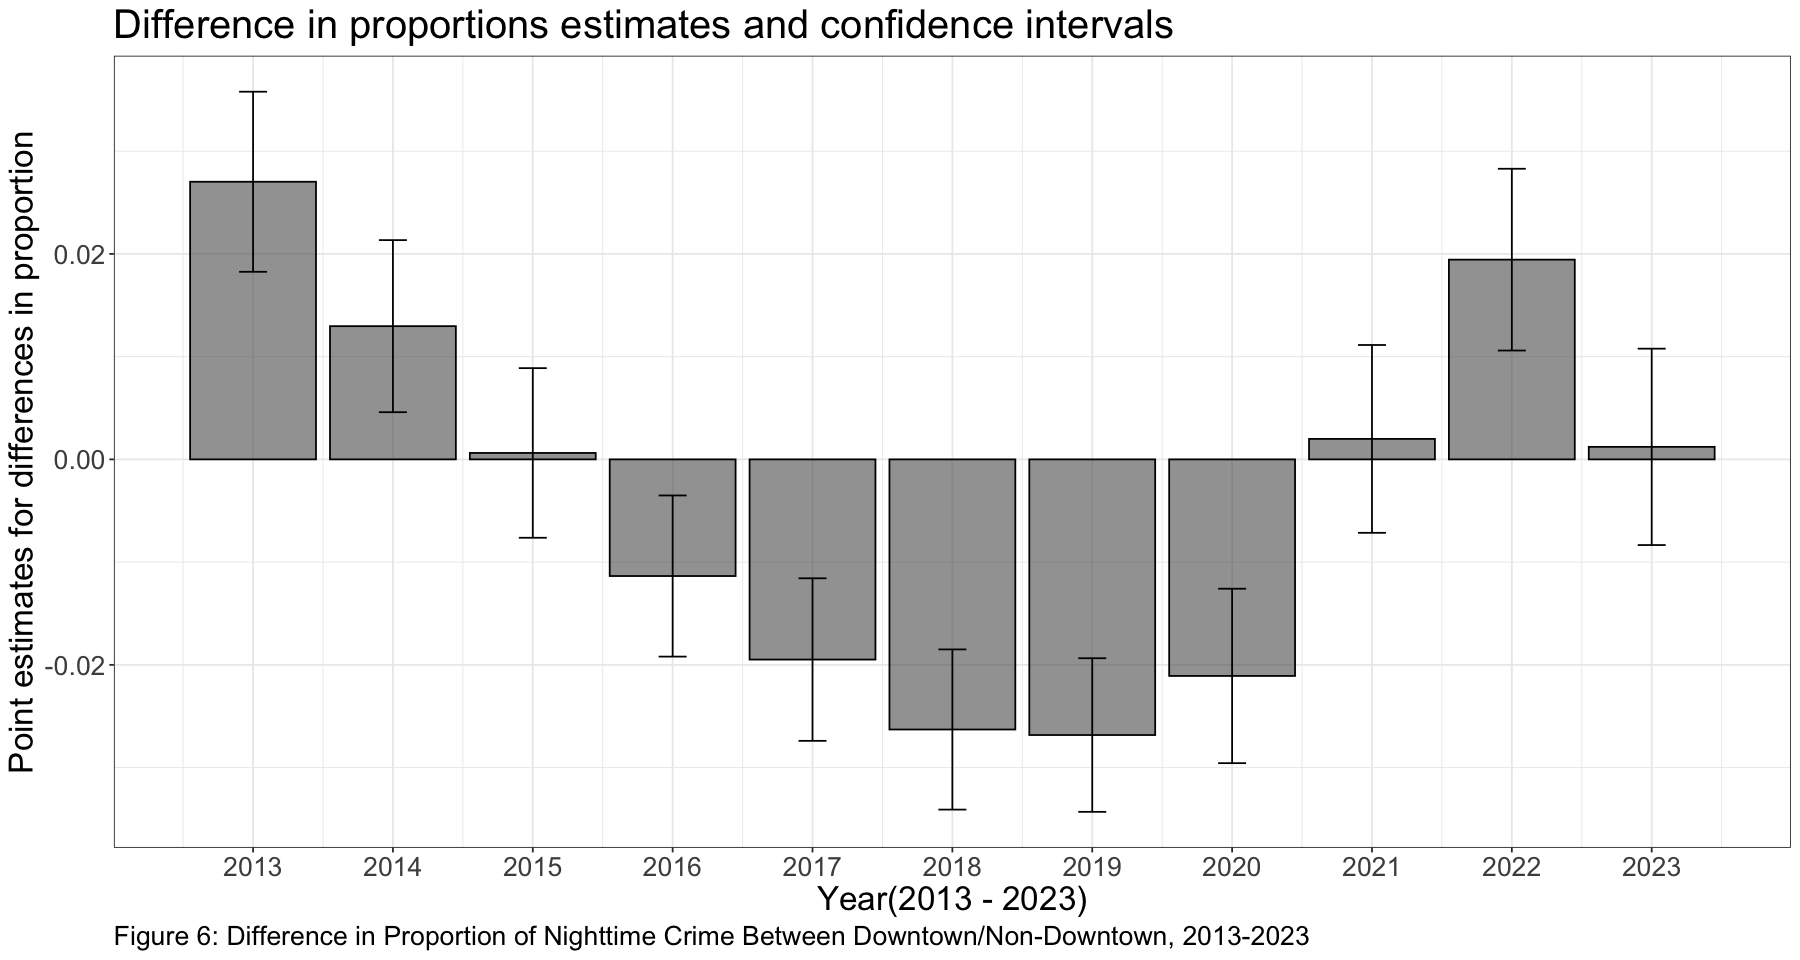

In [31]:
# creating a set of boxplots to display the test statistics and confidence intervals
prop_test_13_23 |>
    ggplot(aes(x = year, y = (estimate1 - estimate2))) +
    geom_bar(stat = "identity", 
             colour="black",
             alpha = .6) +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high),size = 0.5, color = "black", width=.2) +
    theme_bw() +
    scale_x_continuous(breaks = seq(2013,2023,1)) +
    xlab("Year(2013 - 2023)") +
    ylab("Point estimates for differences in proportion") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Difference in proportions estimates and confidence intervals") + 
    labs(caption = "Figure 6: Difference in Proportion of Nighttime Crime Between Downtown/Non-Downtown, 2013-2023") +
    theme(plot.caption = element_text(hjust = 0))

In Figure 6, we see that the confidence interval for true difference in proportion is quite different. Of the 11 confidence intervals, 3 suggest that a higher proportion of crime happens downtown, 3 suggest no difference in proportion, and 5 suggest a higher proportion of crime happens in non-downtown.

### Part II: Hypothesis Testing Using all Data

For this time, we try to block the variable of years by combing all past 10 years data together to do hypothesis test.

In [20]:
# finding summary statistics over all 2013-2023 data
overall_summary <- crime_AllNBHD_AllTime_summary |>
    filter(time == "Night") |>
    group_by(region) |>
    summarize(count = sum(count),
              aggregate = sum(aggregate))

overall_summary

region,count,aggregate
<chr>,<int>,<int>
downtown,106037,197259
other,125481,231012


_table 7.a_ : This table shows the statistic of combing the all past 10 years data together, the count of nighttime crimes in two different areas and the total number of crimes in two areas.

In [21]:
# conducting the same hypothesis test
results_all <- tidy(prop.test(x = c(106037, 125481), 
               n = c(197259, 231012), 
               alternative = "two.sided", 
               conf.level = 0.9, 
               correct = F)
    )
results_all

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.5375522,0.5431796,13.5676,0.0002301235,1,-0.008140523,-0.003114323,2-sample test for equality of proportions without continuity correction,two.sided


_table 7.b_ : This table shows the result of the proportional hypothesis test. The `p-value` is the probability of observing a differences in the proportion of crimes happened in the night in two different areas (downtown and nondowntown) at least as different as hypothesis of two proportions are same. The value of it, $0.0002$ shows that the null hypothesis is rear. It suggests a 90% confidence interval to have a sense of truely difference is negative, which means the proportion for nondowntown area is slightly lower than downtown area.

In [22]:
# obtaining the p-value from all data
p_value_all <- results_all |>
    select(p.value) |>
    pull()
p_value_all

[1] 0.0002301235

In [23]:
# obtaining the confidence interval for difference in proportions (downtown - non-downtown) from all data
conf_interval_all <- tibble(
    lower_ci = results_all$conf.low,
    upper_ci = results_all$conf.high
)
conf_interval_all

lower_ci,upper_ci
<dbl>,<dbl>
-0.008140523,-0.003114323


Using all the data, we have obtained a p-value of 0.0002 and the confidence interval for difference in proportions between downtown and non-downtown areas is (-0.0081, -0.0031).

## <u>Methods</u>
We have a large sample size (428k) and we use well established statistical methods to draw our conclusions, which make this report trustworthy.

The main downside is the data is only from Vancouver, so we will apply our results to cities similar to Vancouver, which we defined as all Major North American Metropolitan Cities. From our plots we can see that between different years, the number/proportion of crimes varies, so we will only use the data from recent years, since that data will be most similar to the near future. We will use a hypothesis test to see if the proportion(night crimes/total crimes) differs between the downtown and non downtown areas, to see if this has an effect on the proportion. We will also be creating a bootstrap confidence interval(CI) and if possible a theory based CI to give a plausible range of values for what the true proportion could be will be since our data comes from a sample, we need to take into account the effect of sampling variation [4], 

We would expect to find that the proportion of crimes that occur at night to be quite close to 50%, with a slight bias towards >50%. We also expect that the proportion of crimes that occur downtown at night to be higher than other areas, given that typically downtown areas have more of a nightlife

The impact of our findings could be that police use it to decide where its best to allocate police resources.

A future question that we could have would be looking at the same proportions, but for each category of crime, since police often work in different units, so we can allocate specialized police resources where they’re most needed.


## <u>References</u>

[1] Schnelle, J. F., Kirchner, R. E., Casey, J. D., Uselton, P. H., &amp; McNees, M. P. (1977). Patrol Evaluation Research: A multiple-baseline analysis of saturation police patrolling during day and night hours. Journal of Applied Behavior Analysis, 10(1), 33–40. https://doi.org/10.1901/jaba.1977.10-33 

[2] Domínguez, P., &amp; Asahi, K. (2022). Crime-time: How ambient light affects crime. Journal of Economic Geography, 23(2), 299–317. https://doi.org/10.1093/jeg/lbac011 

[3] Vancouver Police Department. (n.d.). Crime Data Download. VPD open data. https://geodash.vpd.ca/opendata/ 

[4] “Apa Dictionary of Psychology.” American Psychological Association, American Psychological Association, dictionary.apa.org/sampling-variability. Accessed 4 Nov. 2023. 